In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
ds =  pd.read_csv('ClusterMain.csv', header=0)

In [3]:
ds = ds.dropna()

In [4]:
ds.set_index('계약일', inplace = True)

In [5]:
#범주형/연속형 변수 분리
cat_col = ['자치구명', '임대건물명', '정책성향']
con_col = ['층', '임대면적', '건축년도', '경제활동인구', '기준금리', '전세가격비율', '아파트매매실거래지수', '회사채수익률', '소비자물가지수', '통화량', '광공업지수']

In [6]:
ds_raw = ds.copy() #원본 데이터 copy

In [7]:
ds = pd.get_dummies(ds, columns=cat_col, drop_first=True)

In [8]:
X = ds.drop(columns='보증금')
y = ds[['보증금']]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [10]:
#연속형 변수 스케일링
scaler = StandardScaler()
scaler.fit(X_train.loc[:,con_col])

X_train.loc[:,con_col] = scaler.transform(X_train.loc[:,con_col])
X_test.loc[:,con_col]  = scaler.transform(X_test.loc[:,con_col])
X_val.loc[:,con_col]   = scaler.transform(X_val.loc[:,con_col])

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               #input_shape=(ds.shape[1], ds.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [16]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(X_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(X_val, y_val), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200


ValueError: in user code:

    File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_2" (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 39)
    
    Call arguments received by layer "sequential_2" (type Sequential):
      • inputs=tf.Tensor(shape=(None, 39), dtype=float64)
      • training=True
      • mask=None


In [ ]:
model.load_weights(filename)
pred = model.predict(X_test)

pred.shape

6/6 [==============================] - 0s 1ms/step


(185, 1)

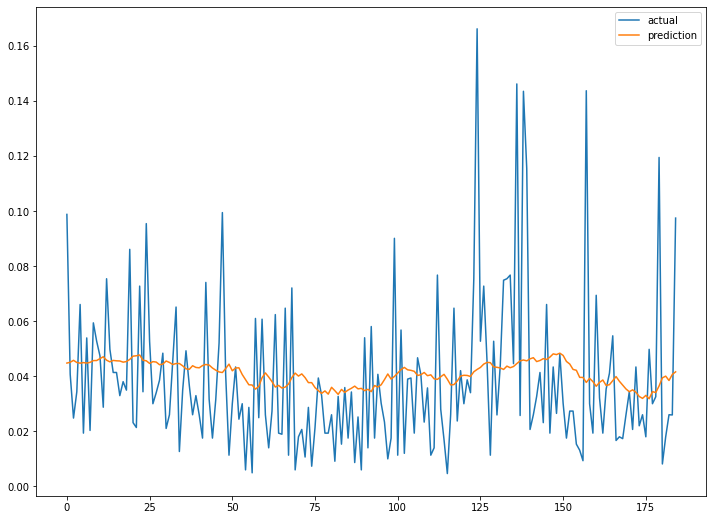

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

In [ ]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(test_label, pred):.3f}")

MAPE: 86.430


In [ ]:
from sklearn import metrics

print("MAE : " + str(metrics.mean_absolute_error(test_label, pred)))
print("MSE : " + str(metrics.mean_squared_error(test_label, pred)))
print("RMSE : " + str(np.sqrt(metrics.mean_squared_error(test_label, pred))))
print("R^2 : " + str(metrics.r2_score(test_label,pred)))

MAE : 0.020086953
MSE : 0.00074484694
RMSE : 0.027291885
R^2 : 0.028709723213617866
